
# TP2 — Histogram & Contrast Adjustment (Grayscale)

**Auteur :** Loann KAIKA  
**Date :** 2025-09-14  


In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

base_dir = r"C:/Users/loann/Desktop/cv2/Images" 
files = ["pout.tif", "cameraman.tif", "bureau.gif", "rice.tif", "tire.tif", "circuit.tif", "ic.tif"]


## 1) Lecture, histogramme & profil

On lit une image en niveaux de gris avec OpenCV et on affiche son histogramme.

* L’axe **X** correspond aux niveaux de gris possibles $[0,255]$.
* L’axe **Y** indique le nombre de pixels ayant cette intensité.

L’histogramme décrit donc la **répartition des intensités** :

* concentré vers 0 → image sombre,
* concentré vers 255 → image claire,
* étalé sur toute la plage → image contrastée.

En comparant différentes images (`pout.tif`, `cameraman.tif`, etc.), on observe des histogrammes de formes variées selon leur contenu visuel.


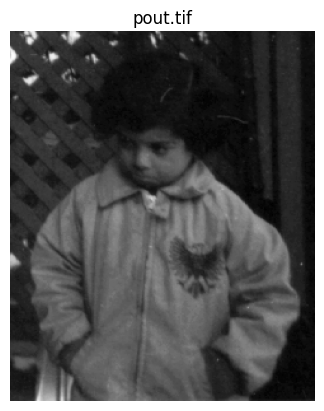

Min = 74 | Max = 224


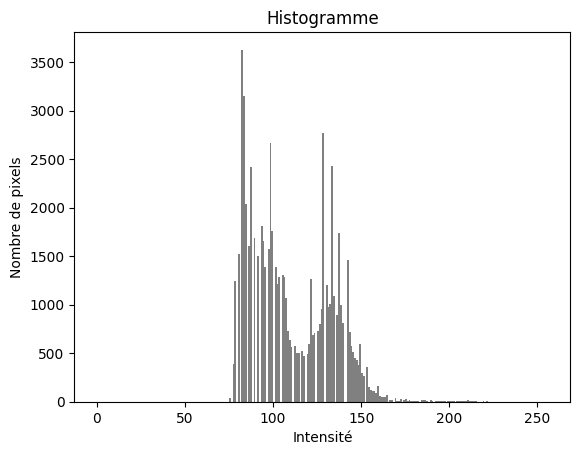

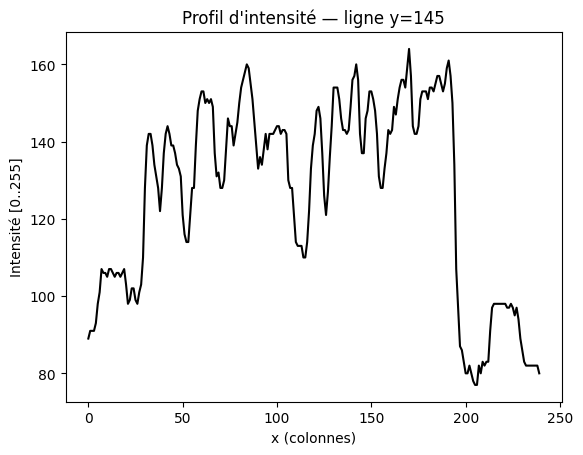

array([ 89,  91,  91,  91,  93,  98, 101, 107, 106, 106, 105, 107, 107,
       106, 105, 106, 106, 105, 106, 107, 103,  98,  99, 102, 102,  99,
        98, 101, 103, 110, 128, 139, 142, 142, 139, 134, 131, 128, 122,
       128, 137, 142, 144, 142, 139, 139, 137, 134, 133, 131, 121, 116,
       114, 114, 121, 128, 128, 139, 148, 151, 153, 153, 150, 151, 150,
       151, 149, 137, 131, 132, 128, 128, 130, 138, 146, 144, 144, 139,
       142, 145, 150, 154, 156, 158, 160, 159, 155, 151, 145, 139, 133,
       136, 134, 138, 142, 138, 142, 142, 142, 143, 144, 144, 142, 143,
       143, 142, 130, 128, 128, 121, 114, 113, 113, 113, 110, 110, 114,
       122, 133, 139, 142, 148, 149, 146, 137, 126, 121, 127, 136, 144,
       154, 154, 154, 151, 146, 143, 143, 142, 143, 149, 156, 157, 160,
       156, 142, 137, 137, 146, 148, 153, 153, 151, 148, 142, 131, 128,
       128, 133, 137, 143, 142, 143, 149, 147, 151, 154, 156, 156, 154,
       159, 164, 157, 144, 142, 142, 144, 151, 153, 153, 153, 15

In [2]:


def load_gray(path: str):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        H, W = 256, 384
        x = np.linspace(0, 1, W, dtype=np.float32)
        grad = np.tile((x*255).astype(np.uint8), (H,1))
        return grad
    return img

def show_gray(img, title="Image (grayscale)"):
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

def line_profile(img, y=None):
    if y is None: y = img.shape[0]//2
    prof = img[y, :]
    plt.plot(prof, color="black")
    plt.title(f"Profil d'intensité — ligne y={y}")
    plt.xlabel("x (colonnes)"); plt.ylabel("Intensité [0..255]")
    plt.show()
    return prof

def hist(img, bins=256):
    plt.hist(img.ravel(), bins=bins, range=(0,256), color="gray")
    plt.title("Histogramme")
    plt.xlabel("Intensité"); plt.ylabel("Nombre de pixels")
    plt.show()

def stats(img):
    m, M = int(img.min()), int(img.max())
    print(f"Min = {m} | Max = {M}")
    return m, M

img_path = str(Path(base_dir)/files[0])
img = load_gray(img_path)
show_gray(img, files[0])
stats(img); hist(img); line_profile(img)



## 2) Normalisation linéaire (min–max)

On calcule les niveaux extrêmes de l’image :

$$
m = \min(I), \quad M = \max(I).
$$

Puis on applique une **transformation affine** qui envoie $m \mapsto 0$ et $M \mapsto 255$ :

$$
I'(x,y) = \frac{I(x,y) - m}{M - m} \cdot 255
$$

* Cette opération **étale l’histogramme** sur toute la plage $[0,255]$
* Le contraste global de l’image est ainsi **renforcé** : les zones sombres deviennent plus noires et les zones claires plus blanches.




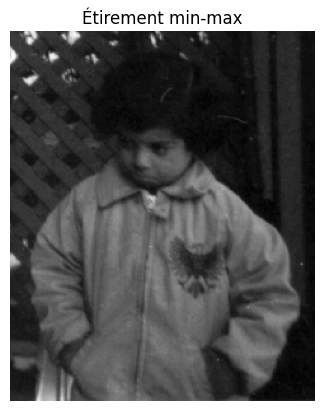

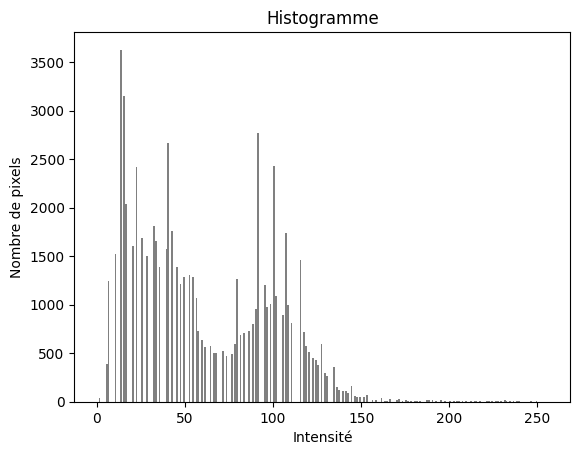

In [3]:

def contrast_stretch(img):
    m, M = img.min(), img.max()
    a = 255.0/(M-m)
    b = -a*m
    out = a*img.astype(np.float32)+b
    return np.clip(out,0,255).astype(np.uint8)

out = contrast_stretch(img)
show_gray(out, "Étirement min-max")
hist(out)



## 3) Transformation affine

On applique une transformation linéaire de la forme :

$$
I'(x,y) = a \cdot I(x,y) + b,
$$

avec $a$ un **gain** (contraste) et $b$ un **offset** (luminosité).

* Si $a > 1$, le contraste est renforcé ; si $0 < a < 1$, il est réduit.
* Si $b > 0$, l’image est éclaircie ; si $b < 0$, elle est assombrie.
* Les valeurs sont ensuite **clippées** dans $[0,255]$ pour rester valides en 8 bits.

Cette transformation permet de corriger à la fois la **luminosité** et le **contraste** de l’image de manière simple.




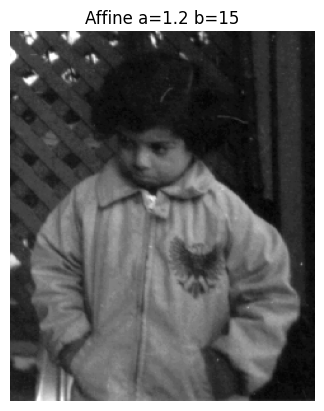

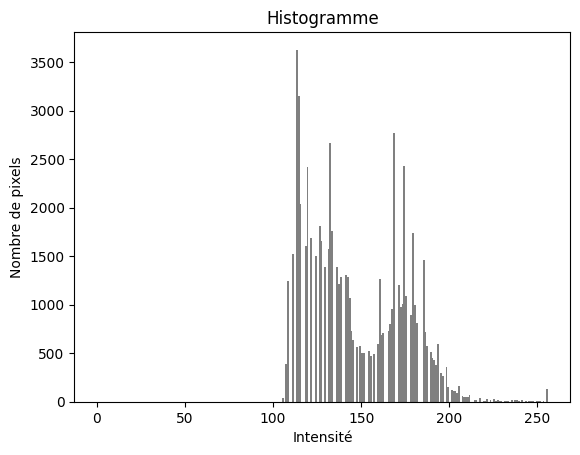

In [4]:

def linear_affine(img, a=1.2, b=15):
    out = a*img.astype(np.float32)+b
    return np.clip(out,0,255).astype(np.uint8)

out = linear_affine(img, a=1.2, b=15)
show_gray(out, "Affine a=1.2 b=15")
hist(out)



## 4) Correction gamma

On applique une transformation **non linéaire** sur chaque pixel :

$$
I'(x,y) = 255 \cdot \left(\frac{I(x,y)}{255}\right)^{\gamma}
$$

* Si $\gamma < 1$ → les basses intensités sont augmentées → l’image est **éclaircie** (détails dans les ombres).
* Si $\gamma > 1$ → les basses intensités sont compressées → l’image est **assombrie** (protection des hautes lumières).

La correction gamma modifie donc la **réponse tonale** de l’image sans changer sa dynamique globale, contrairement à l’étirement linéaire.



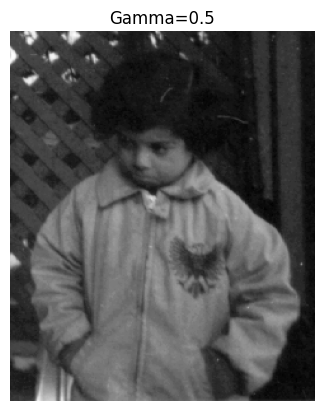

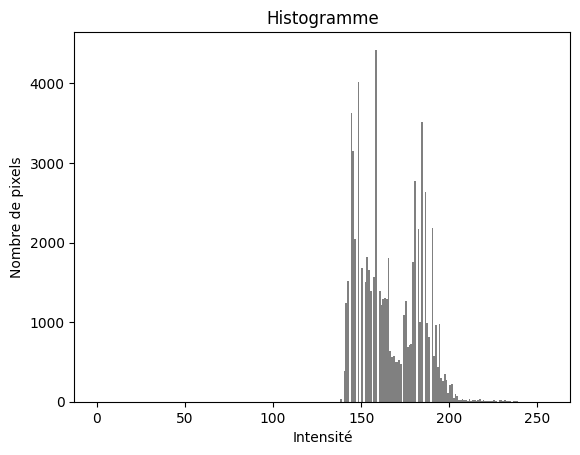

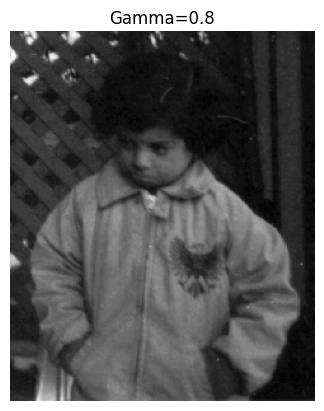

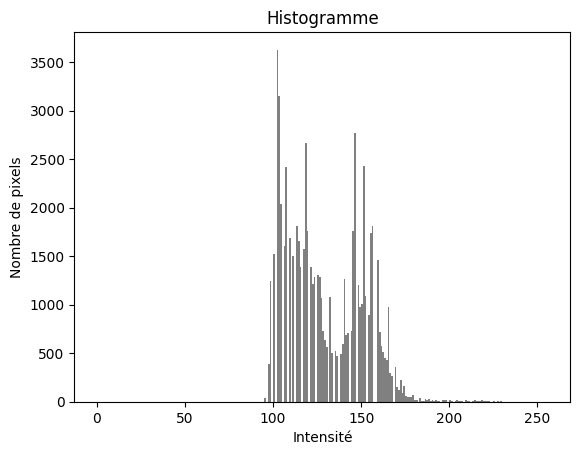

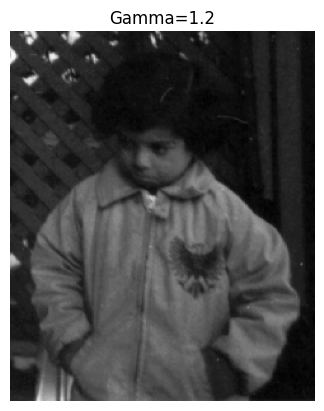

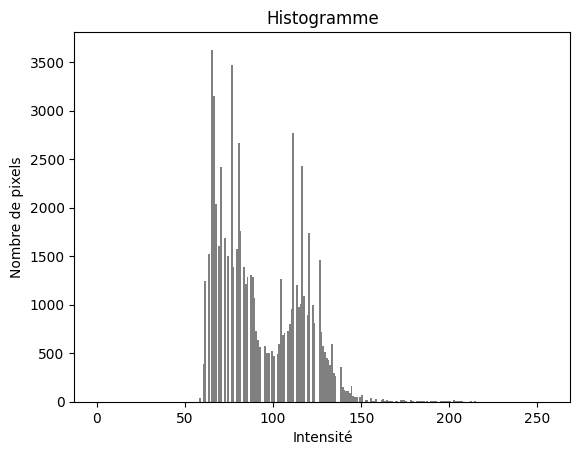

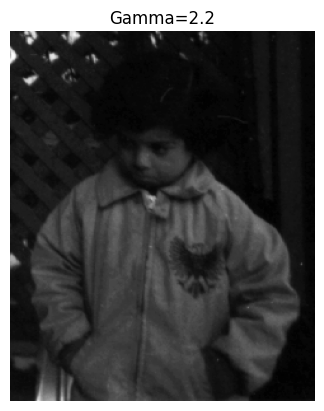

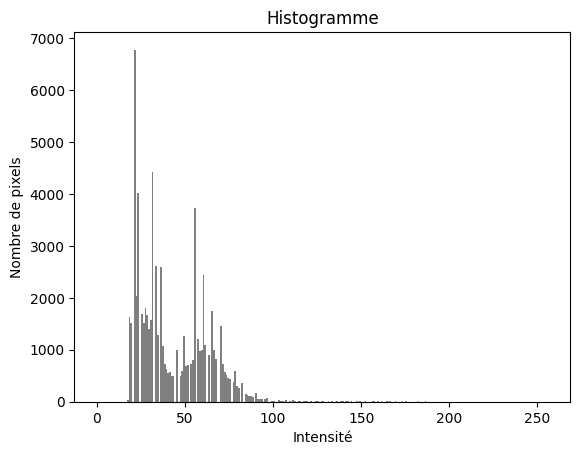

In [5]:

def gamma_correct(img, gamma=0.6):
    x = img.astype(np.float32)/255.0
    y = np.power(x, gamma)
    return np.clip(y*255,0,255).astype(np.uint8)

for g in [0.5, 0.8, 1.2, 2.2]:
    out = gamma_correct(img, g)
    show_gray(out, f"Gamma={g}")
    hist(out)



## 5) Égalisation d'histogramme

L’égalisation vise à redistribuer les intensités pour obtenir un histogramme plus uniforme.

* **Égalisation globale (`cv2.equalizeHist`)** :
  On applique la fonction de répartition cumulative (CDF) de l’histogramme comme transformation.

  $$
  I'(x,y) = \text{round}\!\left(255 \cdot \frac{\text{CDF}(I(x,y))}{\text{CDF}(255)}\right)
  $$

  Le contraste est amélioré surtout dans les zones ternes, mais du bruit peut apparaître.

* **Égalisation locale (CLAHE)** :
  L’image est découpée en tuiles, chacune est égalisée puis recollée avec une limitation du contraste (*clip limit*).
  Permet de renforcer le contraste **localement** tout en évitant l’amplification du bruit.



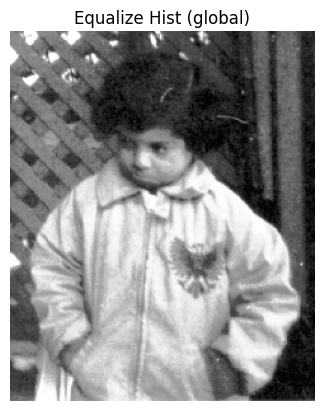

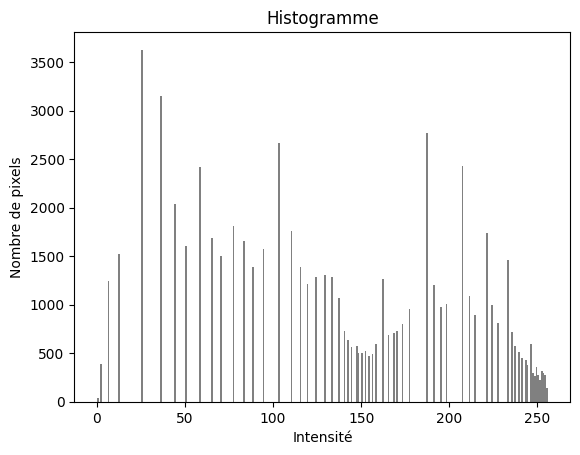

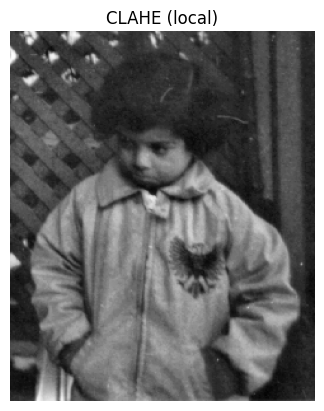

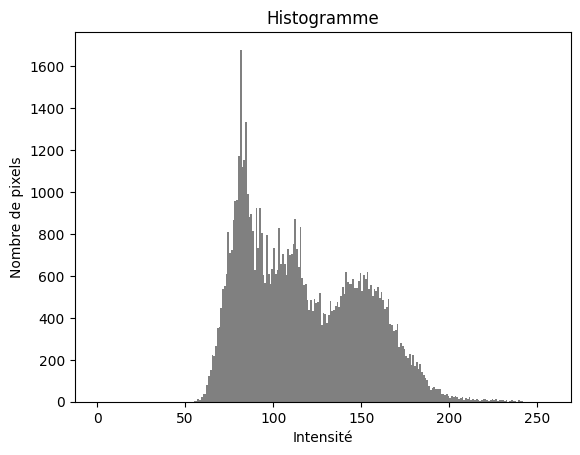

In [6]:

eq = cv2.equalizeHist(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(img)

show_gray(eq, "Equalize Hist (global)")
hist(eq)
show_gray(cl, "CLAHE (local)")
hist(cl)
